<a href="https://www.kaggle.com/code/aisuko/semantic-segmentation-of-satellite-imagery?scriptVersionId=168229384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we are going to build k-Means algorithm from scratch in python using only `numpy` and `pandas` libraries and apply it to real word problem -- semantic segmentation of satellite imagery.

We got two RGB images of the same area with an interval of 23 years, however it's clear that the land surface properties and atmopheric conditions are different. So, we will train two seperate k-Means models, one for each image.

# Loading images

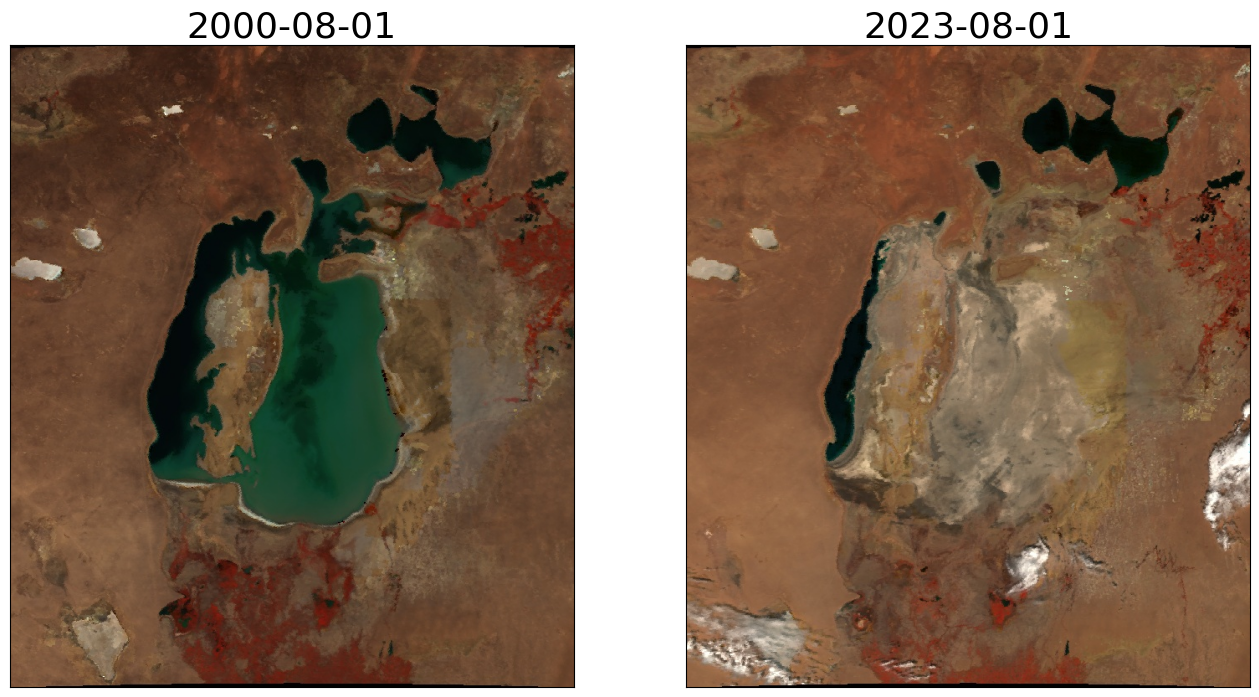

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_2000='/kaggle/input/remote-sensing-imagery-from-modis/MOD_01.jpg'
img_2023='/kaggle/input/remote-sensing-imagery-from-modis/MOD_24.jpg'


def img_show(img, img2):
    fig, ax=plt.subplots(ncols=2, figsize=(16,9))
    ax[0].imshow(img)
    ax[1].imshow(img2)
    for i in range(2):
        ax[i].set_facecolor('black')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    ax[0].set_title('2000-08-01', fontsize=26)
    ax[1].set_title('2023-08-01', fontsize=26)
    plt.show

img=mpimg.imread(img_2000)
img2=mpimg.imread(img_2023)

img_show(img, img2)

# Zoom in Images

Some area covered by the images is quite large, so we zoom in a little bit.

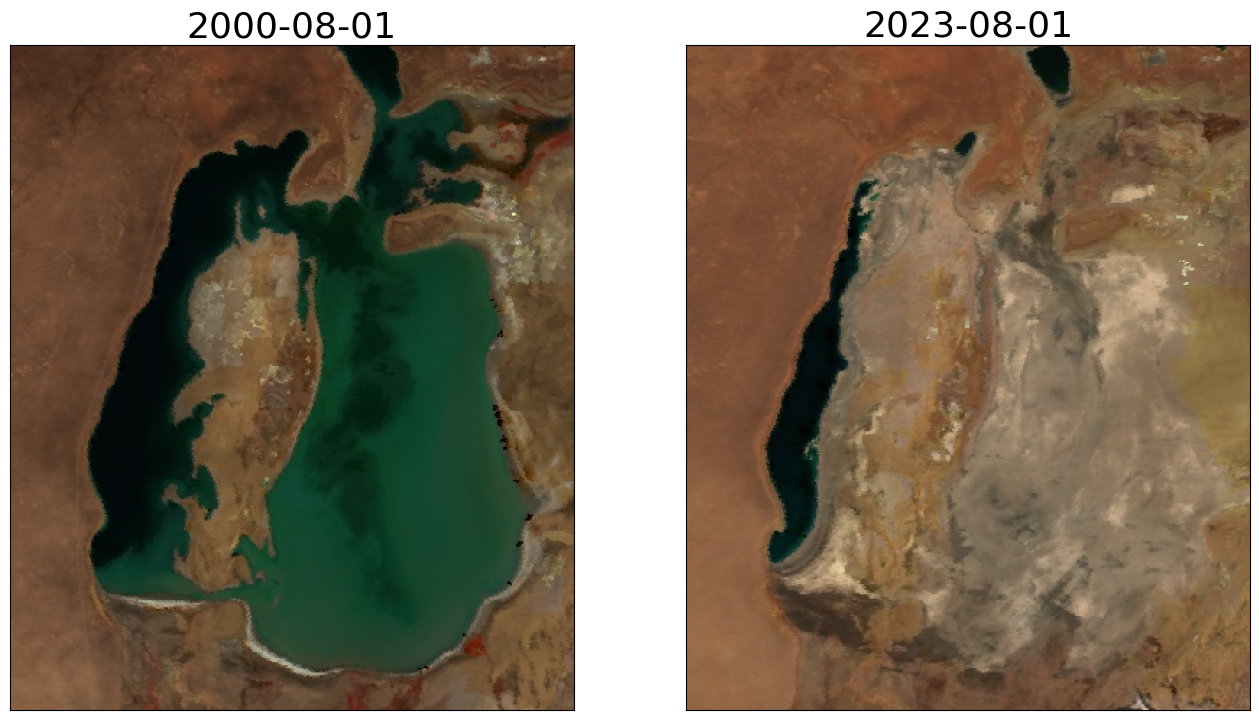

In [2]:
img=img[140:600, 110:500,:]
img2=img2[140:600, 110:500,:]

img_show(img, img2)

# Converting Images to pandas Dataframes

We convert images to pandas dataframes(one column for each image channel).

In [3]:
import pandas as pd

df= pd.DataFrame({'R': img[:,:,0].flatten(), 'G': img[:,:,1].flatten(), 'B':img[:,:,2].flatten()})
df2= pd.DataFrame({'R': img2[:,:,0].flatten(), 'G': img2[:,:,1].flatten(), 'B':img2[:,:,2].flatten()})

# k-Means implementation

In [4]:
import numpy as np

def distance(data, centroids, kind):
    #kind - euclidian, manhattan, chebyshev
    cols=list()
    for i in range(1,k+1):
        if kind=='euclidean':
            data[f'C{i}'] = ((centroids[i-1][0]-data.R)**2+(centroids[i-1][1]-data.G)**2+(centroids[i-1][2]-data.B)**2)**0.5
        elif kind=='manhattan':
            data[f'C{i}'] = abs(centroids[i-1][0]-data.R)+abs(centroids[i-1][1]-data.G)+abs(centroids[i-1][2]-data.B)
        elif kind=='chebyshev':
            merged=pd.concat([centroids[i-1][0]-data.R, centroids[i-1][1]-data.G, centroids[i-1][2]-data.B], axis=1)
            data[f'C{i}'] = merged.max(axis=1)
        cols.append(f'C{i}')
    data['Class'] = data[cols].abs().idxmin(axis=1)
    return data


def kmeans(data, K, kind):
    print(10*'-', f'k={3}\tDistance={kind}', '-'*10)
    L = list()
    new_centroids = data.sample(K).values

    data = distance(data.copy(), new_centroids, kind)
    old_centroids = new_centroids.copy()
    new_centroids = np.array([data[data.Class == Class][['R', 'G', 'B']].mean().values for Class in data.loc[:,'C1':f'C{K}'].columns])
    i = 1
    print(f'Iteration: {i}\tDistance: {abs(new_centroids.mean()-old_centroids.mean())}')
    
    while abs(new_centroids.mean()-old_centroids.mean())>0.001:
        L.append(abs(new_centroids.mean()-old_centroids.mean()))
        data = distance(data, new_centroids, kind)
        old_centroids = new_centroids.copy()
        new_centroids = np.array([data[data.Class == Class][['R', 'G', 'B']].mean().values for Class in data.loc[:,'C1':f'C{K}'].columns])
        #if np.isnan(new_centroids).any(): #in case there is an empty cluster
        i+=1
        print(f'Iteration: {i}\tDistance: {abs(new_centroids.mean()-old_centroids.mean())}')
    print(f"k-Means has ended with {i} iteratinons")
    return data, L

In [5]:
k=3
segmented_1, segmented_2, distances_1, distances_2={},{},{},{}
segmented_1['euclidean'], distances_1['euclidean']=kmeans(df, k, 'euclidean')
segmented_2['euclidean'], distances_2['euclidean']=kmeans(df2, k, 'euclidean')
segmented_1['manhattan'], distances_1['manhattan']=kmeans(df, k, 'manhattan')
segmented_2['manhattan'], distances_2['manhattan']=kmeans(df2, k, 'manhattan')
segmented_1['chebyshev'], distances_1['chebyshev']=kmeans(df, k, 'chebyshev')
segmented_2['chebyshev'], distances_2['chebyshev']=kmeans(df2, k, 'chebyshev')

---------- k=3	Distance=euclidean ----------
Iteration: 1	Distance: 31.95531318395403
Iteration: 2	Distance: 1.4360789353559227
Iteration: 3	Distance: 2.533714145083806
Iteration: 4	Distance: 1.418805844608194
Iteration: 5	Distance: 1.7934862325199106
Iteration: 6	Distance: 1.437097866113504
Iteration: 7	Distance: 1.0943268357012101
Iteration: 8	Distance: 0.8100037200404486
Iteration: 9	Distance: 0.6238686704689371
Iteration: 10	Distance: 0.4266037807966896
Iteration: 11	Distance: 0.24775221909320067
Iteration: 12	Distance: 0.22031717405596396
Iteration: 13	Distance: 0.10754753514100912
Iteration: 14	Distance: 0.032455795072010574
Iteration: 15	Distance: 0.014971098130537541
Iteration: 16	Distance: 0.02841794375084561
Iteration: 17	Distance: 0.012494961829830231
Iteration: 18	Distance: 0.011360914961315416
Iteration: 19	Distance: 0.008808272605833167
Iteration: 20	Distance: 0.0006754820064500677
k-Means has ended with 20 iteratinons
---------- k=3	Distance=euclidean ----------
Iteratio

# Visualization

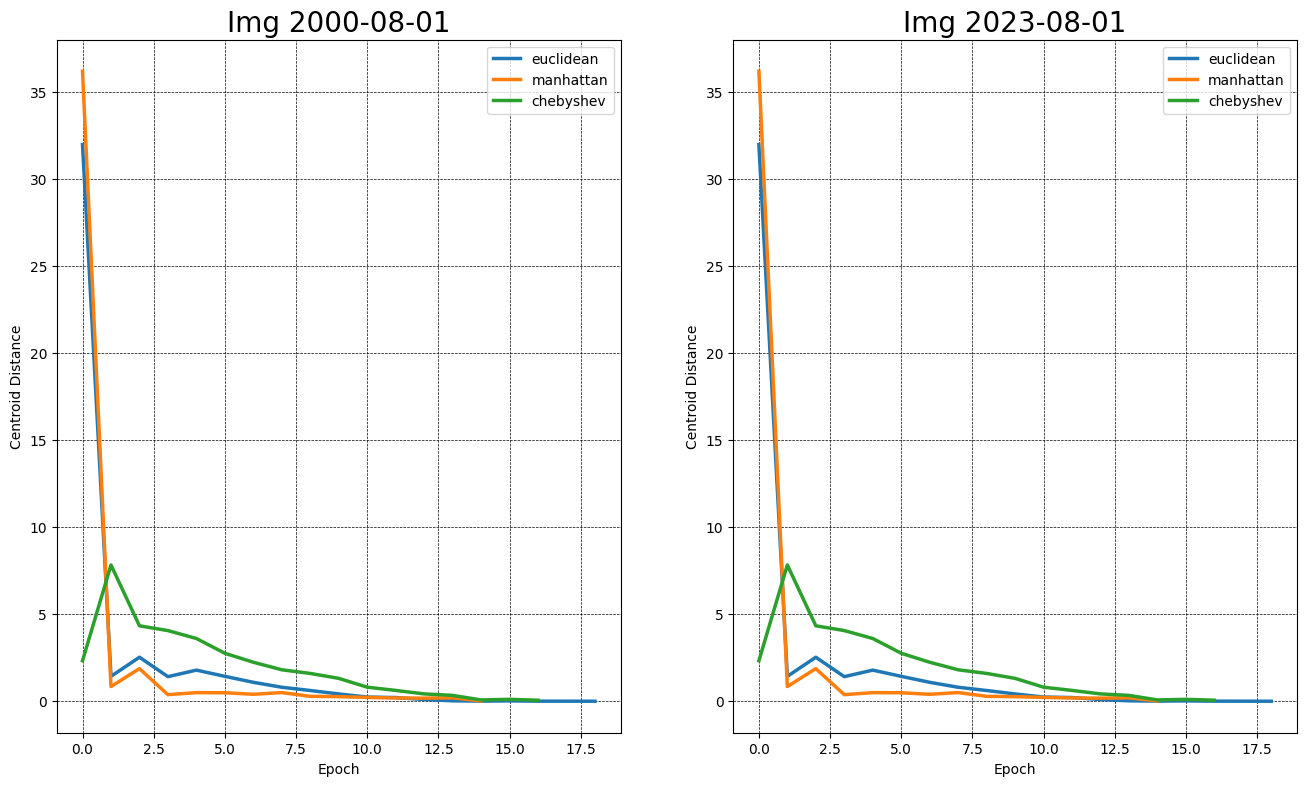

In [6]:
fig, ax=plt.subplots(ncols=2, figsize=(16,9))
for key in distances_1.keys():
    ax[0].plot(distances_1[key], lw=2.5, label=key)
    ax[1].plot(distances_1[key], lw=2.5, label=key)
    
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Centroid Distance')
    ax[i].grid(color='black', ls='--', lw=0.5)
    ax[i].legend()
    
ax[0].set_title('Img 2000-08-01', fontsize=20)
ax[1].set_title('Img 2023-08-01', fontsize=20)
plt.savefig('comparison.png')
plt.show()

Before visualization the clusters, let's convert the clusters name into int type:

In [7]:
d={'C1':0, 'C2':1, 'C3':2}
for key in segmented_1.keys():
    segmented_1[key].Class=segmented_1[key].Class.apply(lambda x: d[x])
    segmented_2[key].Class=segmented_2[key].Class.apply(lambda x: d[x])

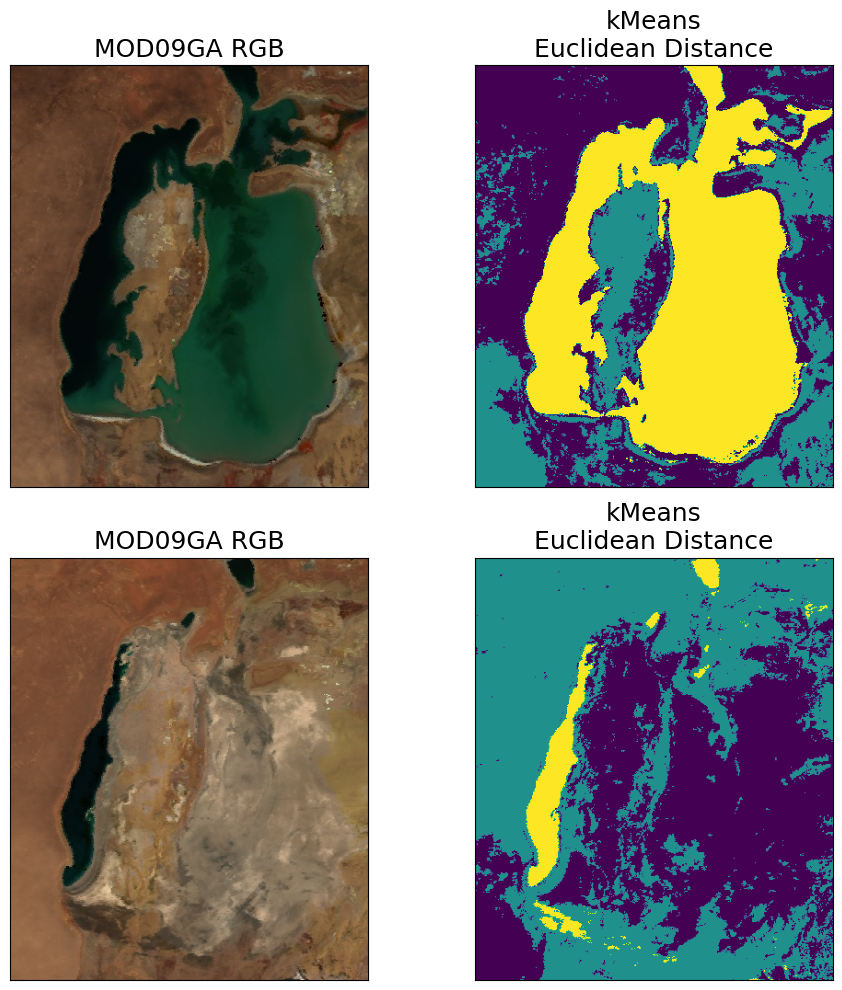

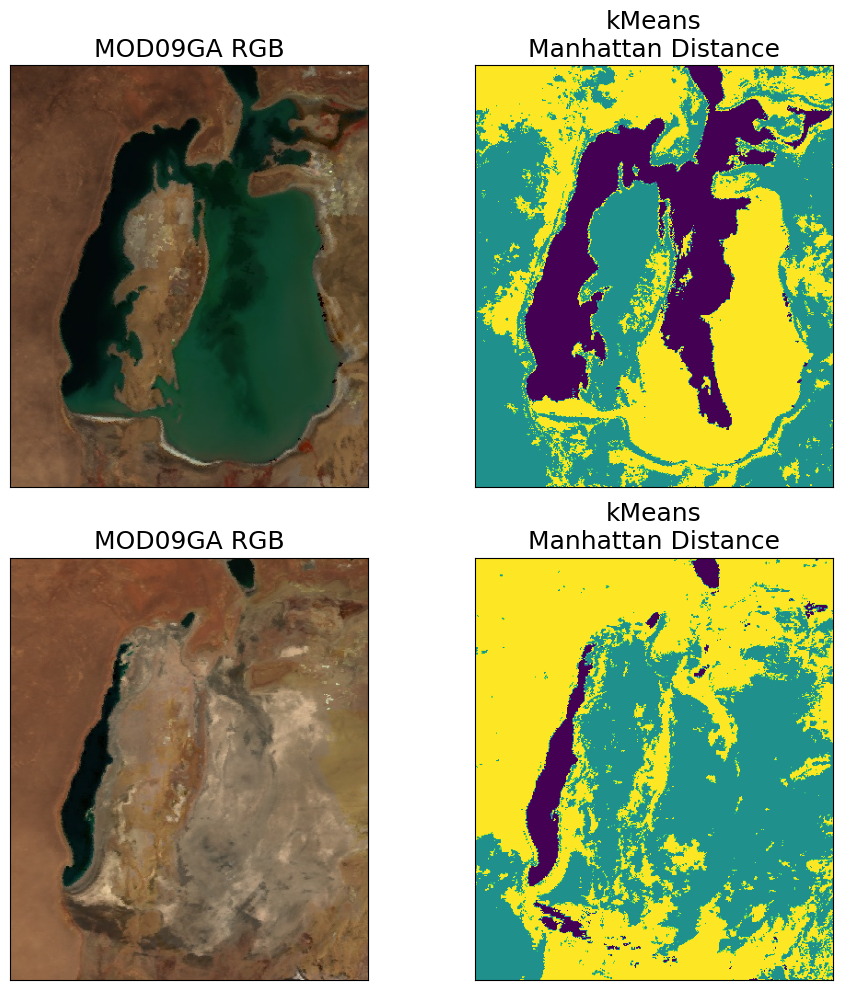

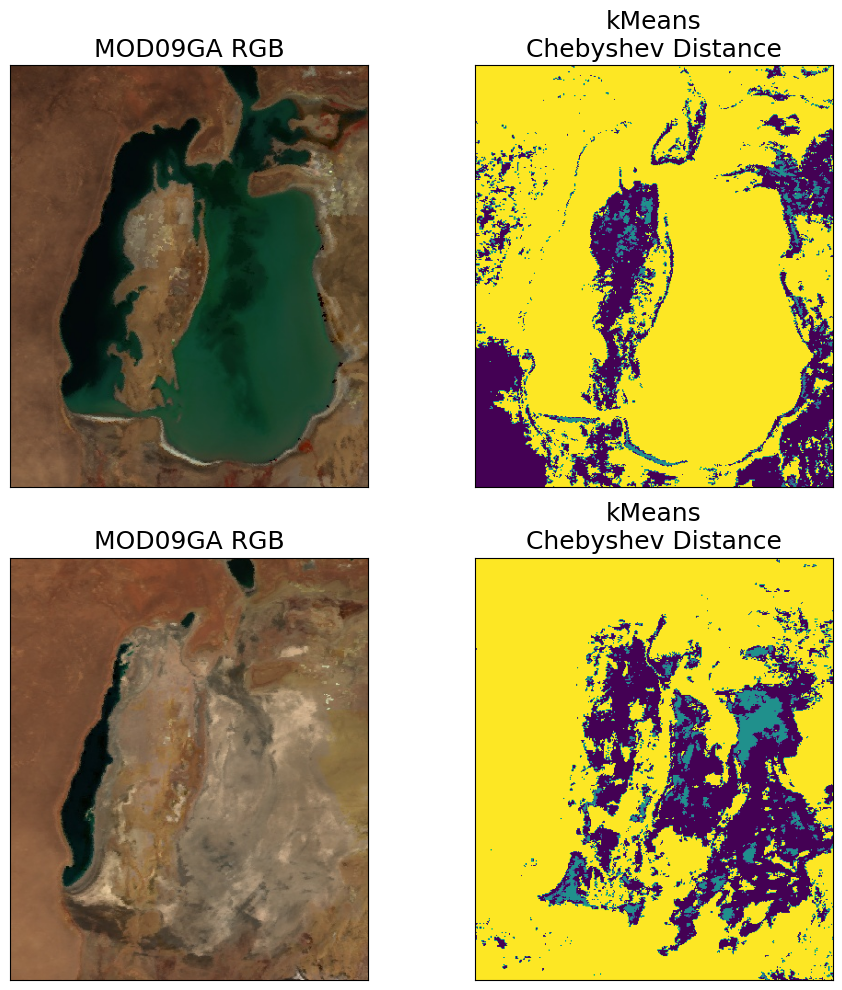

In [8]:
for key in segmented_1.keys():
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    ax[0, 0].imshow(img)
    ax[0, 1].imshow(segmented_1[key].Class.values.reshape(460,390))
    ax[0, 0].set_title('MOD09GA RGB', fontsize=18)
    ax[0, 1].set_title(f'kMeans\n{key[0].upper()+key[1:]} Distance', fontsize=18)

    ax[1, 0].imshow(img2)
    ax[1, 1].imshow(segmented_2[key].Class.values.reshape(460,390))
    ax[1, 0].set_title('MOD09GA RGB', fontsize=18)
    ax[1, 1].set_title(f'kMeans\n{key[0].upper()+key[1:]} Distance', fontsize=18)

    for i in range(2):
        for j in range(2):
            ax[i, j].set_facecolor('black')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    plt.savefig(f'{key}.png')
    plt.tight_layout()
    plt.show()
     

# Scores

Here, we are going to use the Silhouette Coefficient. This metric is perfect for training results assessment when there are no labeled true values for the clustered points.

To calculate it we will use `sklearn` function:

$$s=\frac{b-a}{max(a,b)}$$

* a - the mean distance between a sample and all other points in the same class
* b- the mean distance between a sample and all other points in the *next nearest cluster*

In [9]:
from sklearn.metrics import silhouette_score

scores_1, scores_2= {}, {}
for key in segmented_1.keys():
    scores_1[key]=round(silhouette_score(segmented_1[key].loc[:,:'C3'], segmented_1[key].Class, metric=key),2)
    scores_2[key]=round(silhouette_score(segmented_2[key].loc[:,:'C3'], segmented_2[key].Class, metric=key),2)
    print(f'Distance: {key}\t Img 1:{scores_1[key]}\t Img 2: {scores_2[key]}')

Distance: euclidean	 Img 1:0.55	 Img 2: 0.54
Distance: manhattan	 Img 1:0.5	 Img 2: 0.56
Distance: chebyshev	 Img 1:0.21	 Img 2: 0.29


# Water Surface Change

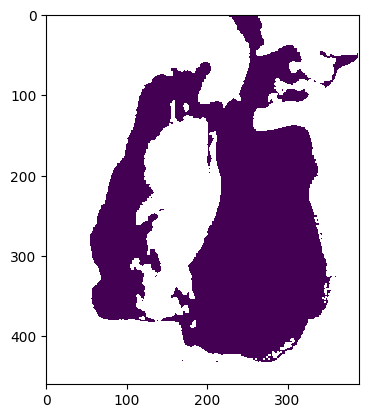

In [10]:
np.count_nonzero(segmented_1[key].Class.values==1)

IMG=segmented_1['euclidean'].Class.values.reshape(460, 390).copy().astype(float)
mask=IMG!=2
IMG[mask]=np.nan
plt.imshow(IMG)

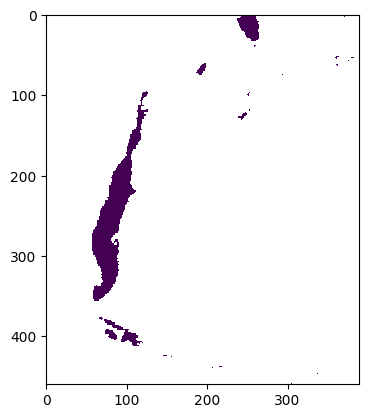

In [11]:
IMG=segmented_2['euclidean'].Class.values.reshape(460, 390).copy().astype(float)
mask=IMG!=2
IMG[mask]=np.nan
plt.imshow(IMG)

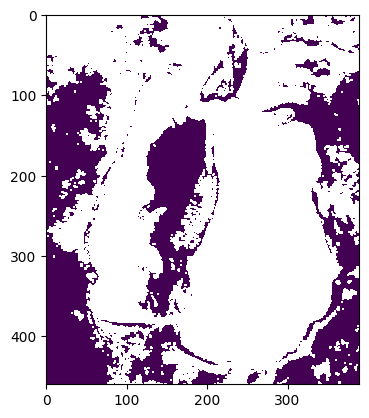

In [12]:
IMG=segmented_1['manhattan'].Class.values.reshape(460, 390).copy().astype(float)
mask=IMG!=1
IMG[mask]=np.nan
plt.imshow(IMG)

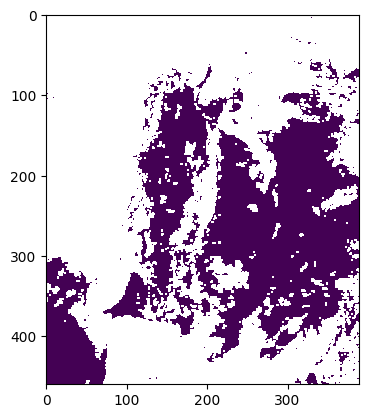

In [13]:
IMG=segmented_2['manhattan'].Class.values.reshape(460, 390).copy().astype(float)
mask=IMG!=1
IMG[mask]=np.nan
plt.imshow(IMG)

In [14]:
for metric, Class in zip(['euclidean', 'manhattan'], [2,1]):
    img1_water=np.count_nonzero(segmented_1[metric].Class.values==Class)*500*500*1e-6
    img2_water=np.count_nonzero(segmented_2[metric].Class.values==Class)*500*500*1e-6

    print(f'Distance: {metric}\tWater Area Before: {round(img1_water)}km\u00b2\tWater Area After: {round(img2_water)}km\u00b2\tChange: -{100-round(img2_water/img1_water*100)}%')

Distance: euclidean	Water Area Before: 17125km²	Water Area After: 1960km²	Change: -89%
Distance: manhattan	Water Area Before: 17348km²	Water Area After: 19487km²	Change: --12%


# Acknowledge

* https://towardsdatascience.com/semantic-segmentation-of-remote-sensing-imagery-using-k-means-e4c165d9218e
* https://github.com/alexxxroz/Medium/blob/main/Medium_k_Means.ipynb
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html